# Imports
Who has the time to implement everything themselves? *Libraries*, man!

In [ ]:
!pip install control
# Colab does not come with this library
import control
import cmath
# Allows you to make complex numbers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.8/432.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import numpy as np
from numpy.typing import ArrayLike
from typing import List
from typing import Tuple
# from typing import str
from math import pi

# Previous Practicum Code
All the code being used from previous Practicums...

## State Feedback Regulator
My state feedback regulator from Practicum 3! One change was made: the call function in **StateFeedbackRegulator()** now can take a *time* value *t* and *setpoint* is now a callable so it can change over time.

In [ ]:
from typing import Callable
class StateFeedbackRegulator:
  def __init__(self,
               K: ArrayLike,
               k_f: float,
               setpoint: Callable) -> None:
    """Store K, k_f, and setpoint for use by the __call__ routine."""
    self.k = K
    self.k_f = k_f
    self.setpoint = setpoint

  def __call__(self, x: ArrayLike, t:float) -> float:
    """Compute the state feedback regulator as discussed in class
    Note: u should be a scalar since this is a single input system.
    
    x: ArrayLike: current state
    t: float: time value"""
    return -1 * self.k @ x +self.k_f*self.setpoint(t)

def feedforward_gain(K: ArrayLike,
                     A: ArrayLike,
                     B: ArrayLike,
                     C: ArrayLike,
                     debug: bool=False) -> float:
  """Calculate the feedforward gain."""
  denom_temp = (A-B@K)
  if debug:
    print(f"Feedforward (A-B@K):\n{denom_temp}")
  denom_temp = np.linalg.inv(denom_temp)
  if debug:
    print(f"Feedforward inv(A-B@K):\n{denom_temp}")
  denom_temp = C@denom_temp
  if debug:
    print(f"Feedforward C@denom_temp:\n{denom_temp}")
  denom = denom_temp@B
  if debug:
    print(f"Feedforward gain step denom_temp@B:\n{denom}")
  return -1/denom

## Controllability
My controllability functions from Practicum 3!

In [ ]:
def ctrb(A: ArrayLike, B: ArrayLike) -> ArrayLike:
  """Return the controlability matrix.
  C = [B AB...]"""
  C = B
  for i in range(1, A.shape[0]):
    temp_a = np.linalg.matrix_power(A, i)
    C = np.hstack((C, temp_a@B))
  return C
  
def is_controllable(C: ArrayLike) -> bool:
  """Calculates determinate of C. If != 0,
  is full rank, and therefore controllable."""
  if np.linalg.det(C) == '0':
    return False
  else:
    return True

## Integration
This is our basic, milk-toast integrator from Practicum 3!

In [ ]:
from typing import Callable

def rk2_step(dyn_func: Callable,
             u_func: Callable,
             x: ArrayLike,
             t: float,
             delta_t: float) -> ArrayLike:
  """Computing f1, f2, and x_k_1. Contains a workaroud
  to the fact that I misunderstood how to write this simulate
  function day1, and have been working with row vectors since,
  when in reality I should've been using columns.
  
  dyn_func: Callable: function being integrated
  u_func: Callable: input function
  x: ArrayLike: x_k value using to estimate x_k_1
  t: float: current time 
  delta_t: float: time step"""
  # Converting the input from a column to a row vector
  x = np.atleast_2d(x).T
  
  f_1 = dyn_func(x=x,u=u_func(t))
  f_2 = dyn_func(x=x + delta_t/2*f_1, u=u_func(t+delta_t/2))

  x_k_1 = x + delta_t*f_2
  # Converting the output from a row to a column vector
  x_k_1 = x_k_1.T
  return x_k_1

def simulate(plant, 
             controller,
             x_0: ArrayLike,
             t_0: float,
             t_f: float,
             delta_t: float) -> Tuple[ArrayLike, ArrayLike]:
  """Generalized integrator function that uses a
  stepper function to be more modular.
  
  plant: what we are controlling
  controller: controller from which input is received
  x_0: ArrayLike: initial conditions
  t_0: float: initial time
  t_f: float: final time
  delta_t: float: time step"""
  # Generate our t values
  t_vals = np.arange(start=t_0, 
                      stop=t_f+delta_t, 
                      step=delta_t)

  # Creating our result array
  x_vals = np.zeros([len(t_vals), np.shape(x_0)[0]])
  x_vals[0] = x_0

  # Using our stepper
  for i in range(1, len(t_vals)):
    u_func = lambda t, state=x_vals[i-1]: controller(state, t)
    x_vals[i] = rk2_step(dyn_func=plant.dynamics,
                         u_func=u_func,
                         x=x_vals[i-1],
                         t=t_vals[i-1],
                         delta_t=delta_t)
  return t_vals, x_vals

# WIP - Wheeled Inverted Pendulum
The basic idea of a Wheeled Inverted Pendulum (**WIP**) is essentially a unicycle with a motor in the wheel. We want to be able to move the vehicle at speed without dragging the "seat" or pendulum along the ground. A visual depiction of this can be seen below:

<center><img src='https://drive.google.com/uc?export=view&id=1zFGCQ2SMbHt0dKizuH-LSQ_gva6EPIEr' width="50%"></center>

Here are our state variables and what they mean:
$$\phi= \text{angle of body}$$
$$\theta= \text{angle of wheel}$$

$$x=\begin{bmatrix}\phi & \dot{\phi} & \dot{\theta}\end{bmatrix}$$

For our implementation, as previously described, we want to control the speed of the robot - so the speed of the wheel, $\dot{\theta}$. To accomplish this, we will make our C matrix:
$$C=\begin{bmatrix}0 & 0 & 1\end{bmatrix}$$
This will allow us to control the speed of our **WIP**!

In [ ]:
class WIP:
  def __init__(self) -> None:
    """Init A,B, and C arrays."""
    self.A = self._init_A()
    self.B = self._init_B()
    self.C = self._init_C()
  
  def _init_A(self) -> ArrayLike:
    """Return A."""
    A = np.array([
      [0, 1, 0],
      [29.77, -0.244, 0.284],
      [-46.82, 1.242, -1.533],
    ])
    return A
  
  def _init_B(self) -> ArrayLike:
    """Return B."""
    B = np.array([
        [0],
        [-7.714],
        [39.22],
    ])
    return B
  
  def _init_C(self) -> ArrayLike:
    """Return C."""
    C = np.array(
        [0, 0, 1]
    )
    return C
  
  def __str__(self) -> str:
    """Return str in form of x_dot = Ax+B"""
    top = "x_dot = Ax+B\n"
    top+= f"A=\n{self.A}\nB=\n{self.B}\n"
    bottom = "y = Cx\n"
    bottom += f"C=\n{self.C}"
    return (top + bottom)
  
  def dynamics(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub.
    
    x: ArrayLike: x
    u: float: input"""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

  def output(self, x: ArrayLike) -> float:
    """Returns theta dot.
    
    x: ArrayLike: x"""
    return self.C@x

Now we're going to try to initialize it and see what happens....

In [ ]:
wip = WIP()
print(wip)

x_dot = Ax+B
A=
[[  0.      1.      0.   ]
 [ 29.77   -0.244   0.284]
 [-46.82    1.242  -1.533]]
B=
[[ 0.   ]
 [-7.714]
 [39.22 ]]
y = Cx
C=
[0 0 1]


Output matches what we expect! These $A$, $B$, and $C$ matrices match the paper we're adapting from.

## Plotting
Per usual, I made a plotting function, because when plotting data, consistency is key :)

In [ ]:
def wip_plot(plant,
               controller,
               x_0: ArrayLike,
               duration: float, 
               delta_t: float,
               title: str):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  plt.figure(figsize=(12,5))
  
  # Simulate
  t_vals, x_vals = simulate(plant=plant,
                            controller=controller,
                            x_0=x_0,
                            t_0=0,
                            t_f=duration,
                            delta_t=delta_t)
  # Plot
  plt.plot(t_vals, [x[0] for x in x_vals], color="purple",
           label="$\phi$")
  plt.plot(t_vals, [x[1] for x in x_vals], color="purple",
           linestyle="-.", label="$\dot{\phi}$")
  plt.plot(t_vals, [x[2] for x in x_vals], color="fuchsia",
           linestyle="-.", label="$\dot{\\theta}$")

  plt.legend()
  
  # Adding appropriate labels
  plt.title(title)
  plt.grid()
  plt.xlabel("Time $(s)$")
  plt.ylabel("Position $(\Theta)$")

I know this is automating something very minor, but if that isn't exactly what coding is for, I'm not sure what is. 

**penalize_input()** implements the following equation:
$$Q_u=\frac{1}{u_{max}^2}$$

In [ ]:
def penalize_input(u_max: float)-> float:
  """Returns 1/u_max^2."""
  return 1/(u_max**2)

## Evaluation 1
First, we need to set up some plotting constants to keep our plots consistent.

In [ ]:
duration = 3
delta_t = 0.001
wip = WIP()
A = wip.A
B = wip.B
C = wip.C

Now for the good stuff: checking to ensure our system is controllable, creating our values for $Q_x$ and $Q_u$, as well as generating our $K$ value using LQR.

We're going to start with the following value for $Q_x$:
$$Q_x = \begin{bmatrix}
0.1 && 0 && 0 \\
0 && 0.1 && 0 \\
0 && 0 && 1 \\
\end{bmatrix}$$
As a reminder, these are our state variables:

$$\phi= \text{angle of body}$$
$$\theta= \text{angle of wheel}$$

$$x=\begin{bmatrix}\phi & \dot{\phi} & \dot{\theta}\end{bmatrix}$$

This $Q_x$ will most heavily penalize $\dot{\theta}$, which is what we're trying to control.

True/False this system is controllable: True


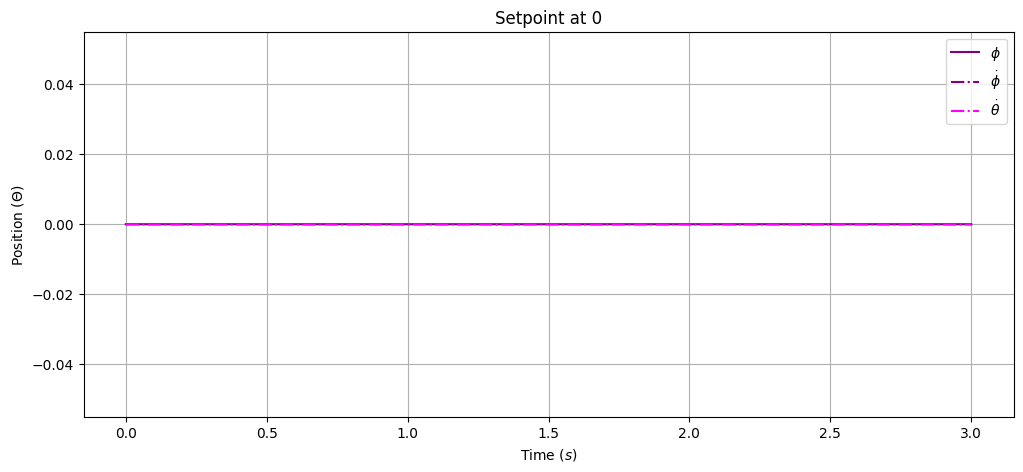

In [ ]:
C_g = ctrb(A=A, B=B)
Q_x = [[0.1, 0, 0], [0, 0.1, 0], [0, 0, 1]]
Q_u = penalize_input(9)
print(f"True/False this system is controllable: {is_controllable(C_g)}")
K, S, E = control.lqr(A, B, Q_x, Q_u)
K_f = feedforward_gain(K=K, A=A, B=B, C=C, debug=False)
setpoint = lambda t: 0

wip_plot(plant=wip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([0, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=f"Setpoint at 0")

Yay, everything is zero at a setpoint of 0 with initial conditions of 0! This should be an easy win, but it's still good to see when trying out a new model.

Now we're going to try something different: an initial $\phi$ of $\frac{pi}{10}$ with a setpoint of $1$. So, physically what's happening is our pendulum isn't quite straight up at first and wants to be moving at $1\frac{rad}{s}$.

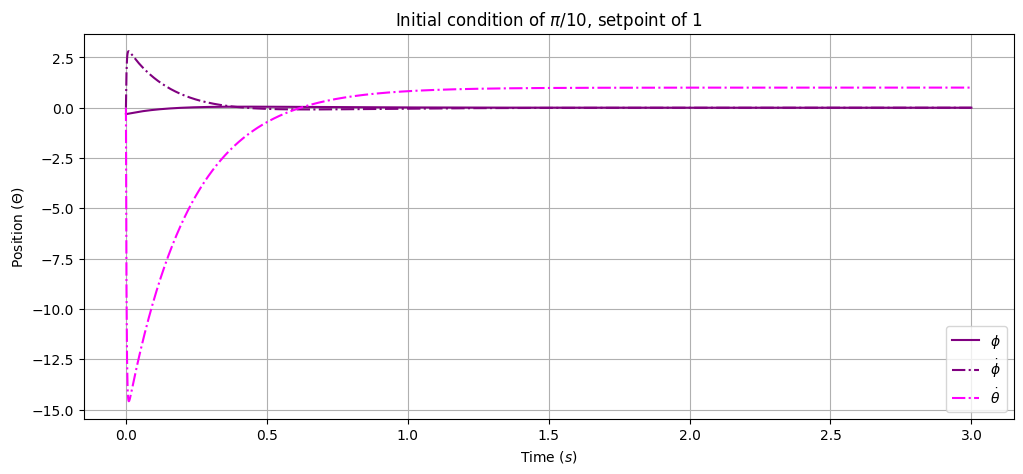

In [ ]:
title= "Initial condition of $\pi$/10, setpoint of 1"
setpoint = lambda t: 1
wip_plot(plant=wip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([-1*math.pi/10, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=title)

Sweet! It works! Our pendulum ends up straight (a deflection of $0$ $rad$)and we end up moving at $1\frac{rad}{s}$. Pretty sick!

## Evaluation 2
Now, let's see what happens if we use the wrong penalties. For example:

$$Q_x = \begin{bmatrix}
1 && 0 && 0 \\
0 && 1 && 0 \\
0 && 0 && 0 \\
\end{bmatrix}$$

Now we're penalizing everything BUT what we want. Let's see what happens:

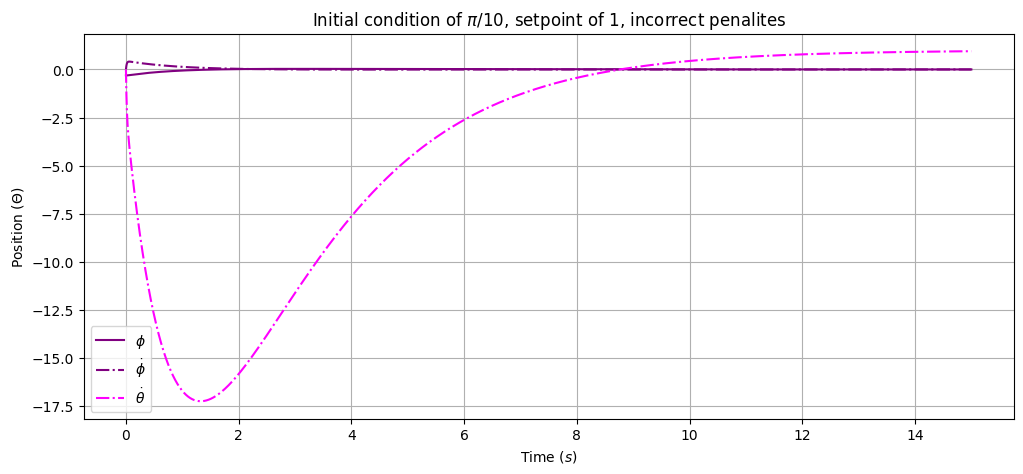

In [ ]:
duration = 15
title= "Initial condition of $\pi$/10, setpoint of 1, incorrect penalites"
Q_x = [[1, 0, 0], [0, 1, 0], [0, 0, 0]]
Q_u = penalize_input(9)
K, S, E = control.lqr(A, B, Q_x, Q_u)
K_f = feedforward_gain(K=K, A=A, B=B, C=C, debug=False)

setpoint = lambda t: 1
wip_plot(plant=wip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([-1*math.pi/10, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=title)

**Pay attention to the x-axis!** Our previous plots used a duration of *3 seconds*, this required a duration of *15 seconds* to get to setpoint. If you consider that in the older plots it took about *1 second* to get to our setpoint, then our new plot with the incorrect penalties is roughly **15 times worse.**

TL;DR: Having correct penalty weights is important.

# DIP - Double Inverted Pendulum
Our double inverted pendulum (**DIP**) is a similar concept to the **WIP** in that it has a wheel and something that sticks up from it. What differentiates this one is that we're controlling a different motor - a motor that tilts the upper body perpindicular to the plane in which the device moves forwards and backwards. By tilting this upper body, the lower body tilts as well, and the device can move in arc motions. Visuals for these explanations can be seen below:
<center>
<img src='https://drive.google.com/uc?export=view&id=14ggpV8skFWNugcb3vkYY8GQVPWK1B76d' width="50%" vertical-align="middle">
<img src='https://drive.google.com/uc?export=view&id=1EWXzSd2ETrISWboA3syLTE19GFUZLw3q' width="49%" vertical-align="middle"></center>

As previously described, in this model, we don't have control over the speed of the wheel. We just have control over the angles of our system. Our states can be seen below:

$$\gamma= \text{angle of upper body}$$
$$\alpha= \text{angle of lower body}$$

$$x=\begin{bmatrix}\alpha & \gamma & \dot{\alpha} & \dot{\gamma}\end{bmatrix}$$

Since we want to control the direction in which our pendulum moves, we want to control the angle of the upper body. To do this, we will use the following C matrix:

$$C=\begin{bmatrix}0 & 1 & 0 & 0\end{bmatrix}$$

Now we can steer our **DIP**!

In [ ]:
class DIP:
  """Double inverted pendulum."""
  def __init__(self) -> None:
    """Init A,B, and C arrays."""
    self.A = self._init_A()
    self.B = self._init_B()
    self.C = self._init_C()
  
  def _init_A(self) -> ArrayLike:
    """Return A."""
    A = np.array([
      [0, 0, 1, 0],
      [0, 0, 0, 1],
      [-11.64, 1.034, -0.035, 0.031],
      [35.68, 24.50, 0.031, -0.257],
    ])
    return A
  
  def _init_B(self) -> ArrayLike:
    """Return B."""
    B = np.array([
        [0],
        [0],
        [8.623],
        [36.00],
    ])
    return B
  
  def _init_C(self) -> ArrayLike:
    """Return C."""
    C = np.array(
        [0, 1, 0, 0]
    )
    return C
  
  def __str__(self) -> str:
    """Return str in form of x_dot = Ax+B"""
    top = "x_dot = Ax+B\n"
    top+= f"A=\n{self.A}\nB=\n{self.B}\n"
    bottom = "y = Cx\n"
    bottom += f"C=\n{self.C}"
    return (top + bottom)
  
  def dynamics(self, x: ArrayLike, u: float) -> ArrayLike:
    """Perform xdot = Ax+Ub.
    
    x: ArrayLike: x
    u: float: input"""
    a_term = np.dot(self.A,x)
    b_term = self.B*u
    return a_term + b_term

  def output(self, x: ArrayLike) -> float:
    """Returns gamma.
    
    x: ArrayLike: x"""
    return self.C@x

Now to make sure it has the values we expect....

In [ ]:
dip = DIP()
print(dip)

x_dot = Ax+B
A=
[[ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]
 [-1.164e+01  1.034e+00 -3.500e-02  3.100e-02]
 [ 3.568e+01  2.450e+01  3.100e-02 -2.570e-01]]
B=
[[ 0.   ]
 [ 0.   ]
 [ 8.623]
 [36.   ]]
y = Cx
C=
[0 1 0 0]


Yup! It matches the values from the paper we're adapting.

## Plotting
Should've called this **YAPF - Yet Another Plotting Function**.

In [ ]:
def dip_plot(plant,
               controller,
               x_0: ArrayLike,
               duration: float, 
               delta_t: float,
               title: str):
  """Plot theta over time on a grid.
  
  plant: plant to be plotted
  controller: controller to be plotted
  x_0: ArrayLike: initial conditions to be plotted
  duration: float: length of time to integrate over
  delta_t: float: time step value to plot
  title: str: title for the plot"""
  # Create a new figure
  plt.figure(figsize=(12,5))
  
  # Simulate
  t_vals, x_vals = simulate(plant=plant,
                            controller=controller,
                            x_0=x_0,
                            t_0=0,
                            t_f=duration,
                            delta_t=delta_t)
  # Plot
  plt.plot(t_vals, [x[0] for x in x_vals], label="$\\alpha$", color="green")
  plt.plot(t_vals, [x[1] for x in x_vals], label="$\gamma$", color="blue")
  plt.plot(t_vals, [x[2] for x in x_vals], linestyle="-.", 
           label="$\dot{\\alpha}$", color="green")
  plt.plot(t_vals, [x[3] for x in x_vals], linestyle="-.",
           label="$\dot{\gamma}$", color="blue")

  plt.legend()
  
  # Adding appropriate labels
  plt.title(title)
  plt.grid()
  plt.xlabel("Time $(s)$")
  plt.ylabel("Position $(\Theta)$")

## Evaluation 1
As before, we need to set up some plotting constants to keep our plots consistent.

In [ ]:
duration = 10
delta_t = 0.001
A = dip.A
B = dip.B
C = dip.C

Now for the fun stuff, once again. As before, we'll start with a $Q_x$ that emphasizes the state we care about the most, in order to ensure it's working:

$$Q_x = \begin{bmatrix}
0.1 && 0 && 0 && 0 \\
0 && 1 && 0 && 0\\
0 && 0 && 0.1 && 0 \\
0 && 0 && 0 && 0.1 \\
\end{bmatrix}$$

As a reminder, here are our state variables:

$$\gamma= \text{angle of upper body}$$
$$\alpha= \text{angle of lower body}$$

$$x=\begin{bmatrix}\alpha & \gamma & \dot{\alpha} & \dot{\gamma}\end{bmatrix}$$

Our $Q_x$ is most heavily penalizing $\gamma$, meaning we're caring the most about the angle of the upper body.

True/False this system is controllable: True


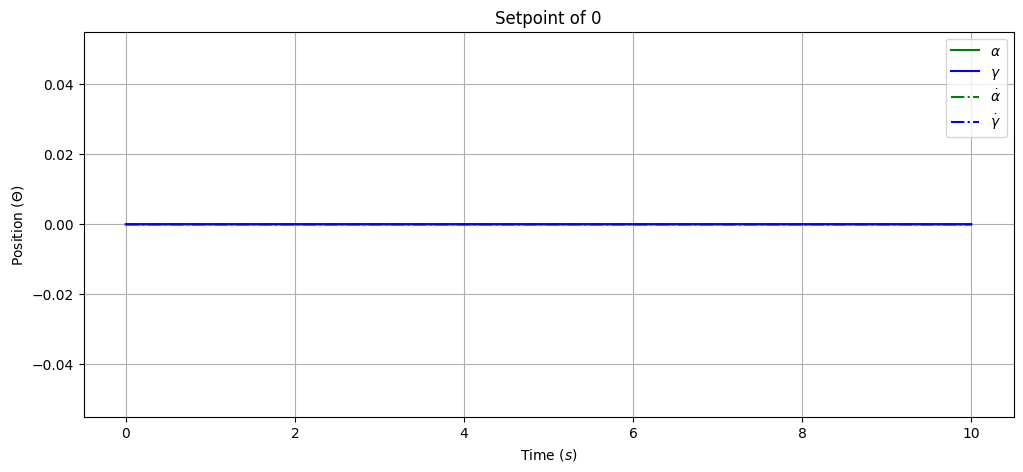

In [ ]:
C_g = ctrb(A=A, B=B)
Q_x = [[0.1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0.1, 0], [0, 0, 0, 0.1]]
Q_u = penalize_input(9)
print(f"True/False this system is controllable: {is_controllable(C_g)}")
K, S, E = control.lqr(A, B, Q_x, Q_u)
K_f = feedforward_gain(K=K, A=A, B=B, C=C, debug=False)
setpoint = lambda t: 0

dip_plot(plant=dip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([0, 0, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=f"Setpoint of {0}")

Similar to before, with everything zero'd out it works!

Now let's try it with a setpoint of 1:

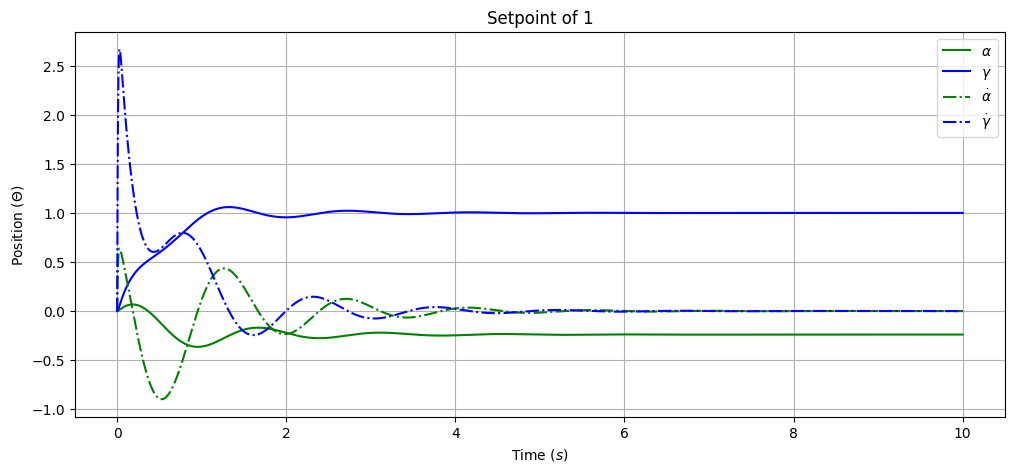

In [ ]:
setpoint = lambda t: 1
dip_plot(plant=dip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([0, 0, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=f"Setpoint of {1}")

Woo-hoo! Our upper body settles at $1$ $rad$ and our lower body deflects as we'd expect!

When I first saw this result, I was confused that the magnitude of $\alpha$ was the opposite of $\gamma$, but after re-examining the diagram of the model above, that is expected. For some reason, the directions of the angles are opposite.

## Evaluation 2
Now, it's finally time to take advantage of the fact that *setpoint* is a callable. 

**piecewise()** implements a piecewise function to turn opposite directions in succession, with some time to reset to zero in-between and afterwards.

In [ ]:
def piecewise(t: float):
  """Implement a piecwise function to turn 
  opposite directions in succession."""
  if (t >= 0.5 and t<=3):
    return 1
  elif (t >= 5.5 and t<=8.0):
    return -1
  else:
    return 0

Lets try it out! We're still using the "correct" penalties to prioritize $\gamma$:

$$Q_x = \begin{bmatrix}
0.1 && 0 && 0 && 0 \\
0 && 1 && 0 && 0\\
0 && 0 && 0.1 && 0 \\
0 && 0 && 0 && 0.1 \\
\end{bmatrix}$$

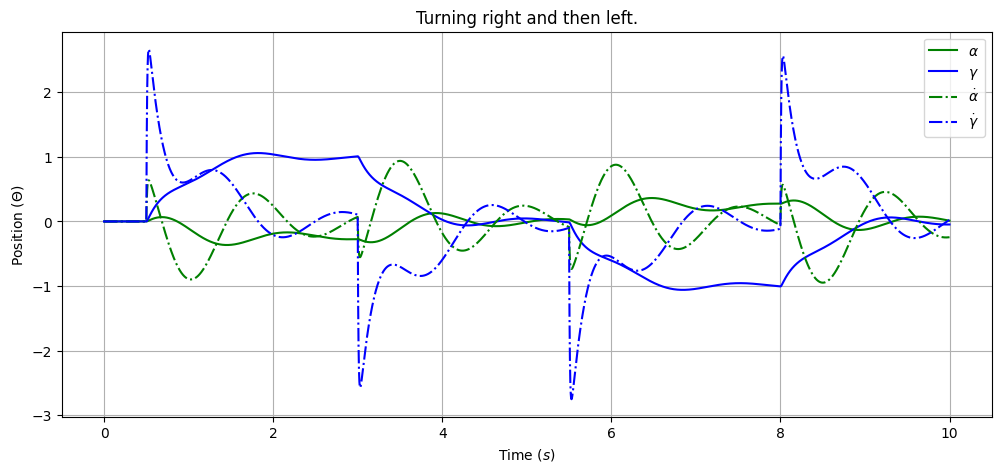

In [ ]:
setpoint = piecewise
dip_plot(plant=dip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([0, 0, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=f"Turning right and then left.")

Look at that! It swings both ways! Absolutely crazy!

## Evaluation 3
Now let's try it with more conservative weights: say, an identity matrix:

$$Q_x = \begin{bmatrix}
1 && 0 && 0 && 0 \\
0 && 1 && 0 && 0\\
0 && 0 && 1 && 0 \\
0 && 0 && 0 && 1 \\
\end{bmatrix}$$

This means that all of our states are penalized equally. AKA the state we care about is no longer special. My prediction is that this will result in a plot that has a harder time getting to the setpoint we desire.

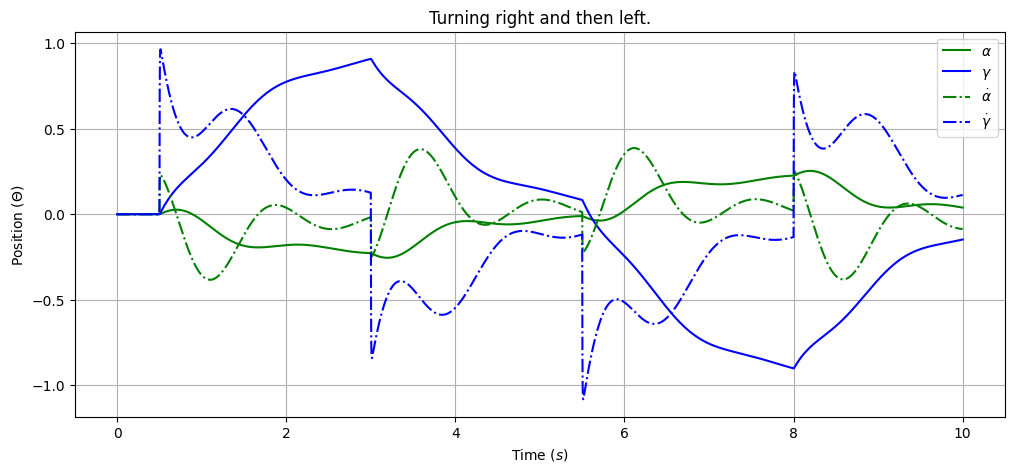

In [ ]:
Q_x = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
Q_u = penalize_input(9)
K, S, E = control.lqr(A, B, Q_x, Q_u)
K_f = feedforward_gain(K=K, A=A, B=B, C=C, debug=False)
setpoint = piecewise

dip_plot(plant=dip,
         controller=StateFeedbackRegulator(K=K, k_f=K_f, setpoint=setpoint),
         x_0=np.array([0, 0, 0, 0]),
         duration=duration,
         delta_t=delta_t,
         title=f"Turning right and then left.")

That is, indeed, a plot. It tries its best to get to the setpoint of 1 for $\gamma$, but it does not succeed in the timeframe it has. This shows the importance of setting up our weights in $Q_x$ properly to priortize the state(s) we care about!

# Reflection
Overall, this honors work has been super interesting. I've never really done a literature review for any of my ECE courses, so it was cool going down that rabbit hole. It also showed me the importance of the sunk-cost fallacy: meaning I'm glad we abandoned that other model we tried first. This is a much better, easier to understand model.

I wish we'd had time to try to fuse these models, but hey, senior year is busy and capstone is important. As it is, I had a really good time implementing this model and messing around with it. This also really showed me the importance of correctly making our penalty matrix $Q_x$, which I didn't get to see as much with the simpler DC Motor model we used in Practicum 4.